# Import modules

Notice: to execute this notebook, you will need some additional packages.
You can install them from Anaconda-Navigator, as seen at lesson. However, many packages don't exist in the anaconda repository. In these cases, you can install them with the command line using `pip install`.

For example

`pip install tweepy`

Required packages (not found in an base installation of Anaconda) are: tweepy, textblob, wordcloud.

In [1]:
import tweepy
from textblob import TextBlob
import json
import pandas as pd 
import nltk

# Input key and secret

To request data from twitter, you need some credential.

Read here to obtain them: https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens

They are individual and secret.

If you don't want to deal with credential, you can use tweets previously stored for the purpose.

In [2]:
consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# Store tweets about a user in a json file

In [30]:
file_name = 'polimi_tweets.json'

You can skip this if you don't have credential, and just load the existing file (next step)

In [4]:
num_tweets = 500         # number of tweets to retrieve
twitter_id = 'polimi'     # userid 

output = open(file_name,"w")
for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    output.write(json.dumps(tweet._json)+'\n') 
output.close()

# Some statistics

A dataframe is a structure defined by the library `pandas` to efficiently store and analyze data.

In [46]:
def load_tweets(file): # a function to load tweets from a file
    with open(file,'r') as f:
        tweets = [json.loads(line) for i, line in enumerate(f.readlines())]
    return tweets


In [5]:
# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)

for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data) # we build a table with 5 columns ("text", "created at", etc.) and tweets as rows

df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type (just a technical thing)

df.sort_values(by='created_at'); # we sort our dataframe by date

### Looking at Favorite and Retweet Counts


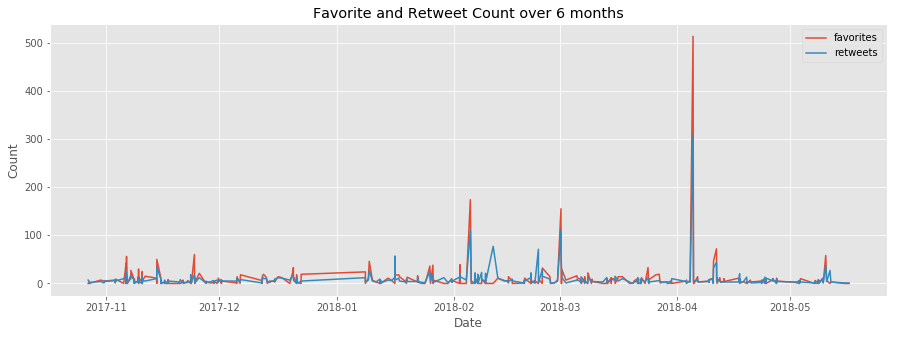

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize = (15,5))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)
plt.title('Favorite and Retweet Count over ' + str(num_months) + ' months')
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(df['created_at'],df['favorite_count'],label='favorite count')
plt.plot(df['created_at'],df['retweet_count'],label='retweet count')
plt.legend(['favorites','retweets'])
plt.show()

In [13]:
top_ten_tweets = df['favorite_count'].sort_values(ascending=False).head(10) # returns a df with first column = index, second column = favorite count

print(twitter_id + "'s top 10 tweets (using favorite count)" + "\n")
for i in range(10): # from 0 to 9
    index = top_ten_tweets.index[i] # get the index of the i-th tweet in the table
    print(str(i+1) + ")" + df.iloc[index]['text']) # df.iloc[i] retrives the i-th tweet in the table
    print("Favorite count: " + str(df.iloc[index]['favorite_count']) + "\n")


polimi's top 10 tweets (using favorite count)

1)"L'insegnamento in inglese al Politecnico di Milano non lede il diritto allo studio, ma favorisce il diritto al lav… https://t.co/HTrolivuJ8
Favorite count: 513

2)"Agli Atenei serve l'inglese." Sentenza sui corsi universitari in inglese: la posizione dei Rettori lombardi oggi s… https://t.co/q6UaDZSrnN
Favorite count: 174

3)Balzo del Politecnico di Milano nella classifica mondiale delle Università @TopUnis.
Il @polimi, unico in Italia è… https://t.co/081izuOnGC
Favorite count: 155

4)Come il @polimi è diventato una delle università migliori al mondo
Un articolo da @thevisioncom 
https://t.co/EDwiVvngtS
Favorite count: 72

5)Cosa ci fa una Ferrari in Rettorato? #JointLabs https://t.co/SKqTiZ9wW5
Favorite count: 60

6)Amalia Ercoli Finzi tra le 100 donne italiane vincenti di @forbesitalia. Professore onorario #polimi, è stata la pr… https://t.co/nW9ouZrg9K
Favorite count: 58

7)La prolusione del prof. Stefano Zanero: La protezione dei ci

### Word Frequency

Now we try to extract the most significant words in the dataset

In [14]:
import string

words = [] # the list will contain all the words in all the tweets
for t in df['text']: # for each tweet's text
    t_words = t.split()
    for w in t_words: # for each word in a tweet
        w_without_punctuation = "".join(char for char in w if char not in string.punctuation) #remove all the characters which are punctuation
        words.append(w_without_punctuation.lower()) #append the word lowered

from collections import Counter
words_counter = Counter(words) # the Counter class automatically counts element in a list

print(words_counter.most_common(20)) #print the most common 10 ones

[('di', 287), ('rt', 194), ('il', 185), ('e', 168), ('polimi', 164), ('per', 134), ('del', 124), ('la', 122), ('a', 116), ('in', 91), ('al', 82), ('è', 67), ('un', 64), ('con', 62), ('inaugurazionepolimi', 61), ('the', 54), ('resta', 52), ('milano', 48), ('politecnico', 47), ('della', 43)]


These words are not very significant...

Problem: many **stopwords**

Solution: get a stopwords corpus and filter

In [16]:
# nltk.download('stopwords') # we download the stopwords corpus of nltk, TO THIS THE FIRST TIME

In [17]:
stopwords = nltk.corpus.stopwords.words('italian') + nltk.corpus.stopwords.words('english')
stopwords.extend(['the','is','of','at','to','be', 'co', 'and','in','a','will','for','on','with','i','you','we','our','my','it',
              '-','by','me','not','just','rt','so','very','she','from','who','her','but','no','or','he','up','would','should',
              'do']) # other useful stopwords...

In [19]:
words_filtered = [w for w in words if w not in stopwords]
words_filtered_counter = Counter(words_filtered)

print(words_filtered_counter.most_common(20)) #print the most common 10 ones

[('polimi', 164), ('inaugurazionepolimi', 61), ('resta', 52), ('milano', 48), ('politecnico', 47), ('rettore', 35), ('oggi', 34), ('ricerca', 33), ('ore', 32), ('', 29), ('progetto', 28), ('design', 28), ('astrosamantha', 25), ('ferruccio', 23), ('docente', 22), ('studenti', 21), ('fondapolimi', 21), ('nuovo', 20), ('beppesala', 20), ('aerospacepolimi', 17)]


Much better

We could represent these with a **bar chart**

Here we use another nice solution: a **wordcloud**


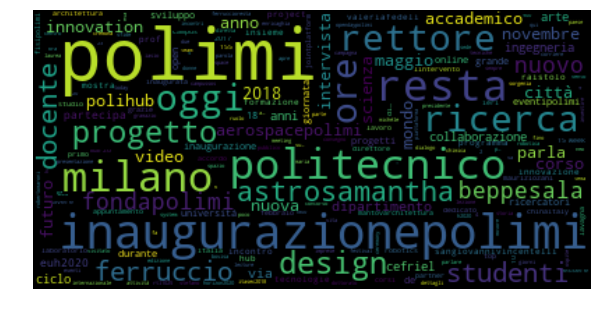

In [21]:
from wordcloud import WordCloud

# generate_from_frequencies() generates a wordcloud starting from sequences. Another solution is to provide a text and use generate()

polimi_wordcloud = WordCloud().generate_from_frequencies(words_filtered_counter)

# once the wordcloud is generated, we show it using matplotlib
plt.figure(figsize=(10,10))
plt.imshow(polimi_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Search for twitter trends

In [22]:
trends_available = api.trends_available() # this shows all thre locations for which a "trend" is available. 23424853 is the ID for Milan, Italy. 1 is the ID for the world

Trends are a list with only 1 element, which is a dictionary with all the trends

In [23]:
trends_milan = api.trends_place(23424853)[0] # get all trends for the provided ID 

In [24]:
print("Trends in Milan as of", trends_milan['as_of'], ":")
for trend in trends_milan['trends']:
    print(trend['name'])

Trends in Milan as of 2018-05-16T15:57:49Z :
#uominiedonne
#cinedebito
giulia
nicolò
giordano
#spread
nilufar
#yates
#osimo
damante
riccanza
fall in line
thiem
corte
dumoulin
michele scarponi
simon
stage 11
freddie
sarri e de laurentiis
laurel
nina moric
#nonestinguerti
#loveyourselftear_d1
#ilicic
#becontentleader
#damellis
#scarponi
#shadowhunters
#fallinline
#shawnmendesthetourbologna
#adnkronos
#karsdorp
#filottrano
#usitalycooperation
#istat
#assisi
#tagadala7
#patrimonio2018
#borsa
#royalvisitynap
#internazionalibnlitalianopen
#moratti
#delaurentiis
#omofobia
#europeforculture
#contrattodigoverno
#16maggio
#gf15
#dimartedi


In [26]:
trends_global = api.trends_place(1)[0] # get all trends for the provided ID 

In [27]:
print("Trends in the world as of", trends_milan['as_of'], ":")
for trend in trends_global['trends']:
    print(trend['name'])

Trends in the world as of 2018-05-16T15:57:49Z :
#alertasismica
#رمضان_كريم
#fallinlinetoday
#sismo
#wednesdaywisdom
çağatay ulusoy
arcelia
trump tower
fall in line
ramzan mubarak
thanks yoongi
larry nassar
iglesias y montero
alerta sísmica
marcel brands
ray wilson
ph armeries
옆자리
donald trump jr.
#16may
#laurel
#sangriawine
#felizmiércoles
#mivkxip
#ramadhan
#englandsquad
#yanny
#loveyourselftear_d1
#tenemossismo
#رمضان_مبارك
#amaneciconganas
#好きなキャラを弱そうに説明する
#uominiedonne
#porlapazyprosperidadvota
#chegadeagrotóxicos
#temblor
#karnatakacmrace
#cinedebito
#poemyourcity
#وش_خطتك_في_رمضان
#あなたが夜になると見せる真の姿
#royalpickuplines
#readyforsomesangriawine
#red4ed
#bienvenidos13
#buenmiercoles
#omatletico
#antesfeiodoque
#الغدا_الختامي
#ramadankareem


# Some analytics

We start with a new dataset (to get more english tweets)

In [35]:
file_name = "microsoft_tweets.json"

In [36]:
# skip this if you don't have the credential, just load the file
output = open(file_name,"w")
for tweet in tweepy.Cursor(api.search, q='#microsoft', rpp=100).items(500): # pagination (rpp tweets per page, max 100) is required crawling twitter
    output.write(json.dumps(tweet._json)+'\n') 
output.close()

In [47]:
tweets = load_tweets(file_name)

In [48]:
print(len(tweets))

500


We start with some cleaning

In [55]:
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    
    # The following (commented) to remove stopwords. Not strictly necessary for this analysis.
    #tweet_filtered = []
    #for w in tweet.split():
    #    if w not in stop_words:
    #        tweet_filtered.append(w)
    #tweet = ' '.join(tweet_filtered)
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

Then we try to assess the *polarity* and the *subjectivity* of each tweet

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [58]:
polarity_value = []
subjectivity_value = []
no_of_tweets = len(tweets)

tweet_subjectivity = {} # a dictionary to store the subjectivity of each string

for tweet in tweets:
    text_cleaned = clean_tweet(tweet['text'])
    analysis = TextBlob(text_cleaned)
    polarity_value.append(float(analysis.sentiment.polarity))
    subjectivity_value.append(float(analysis.sentiment.subjectivity))
    tweet_subjectivity[tweet['text']] = float(analysis.sentiment.subjectivity)
    
avg_pol = sum(polarity_value)/len(polarity_value)
avg_sub = sum(subjectivity_value) /len(subjectivity_value)

print ("Average polarity: ", (avg_pol))
print ("Average subjectivity: ", (avg_sub))

Average polarity:  0.10256758658008658
Average subjectivity:  0.20633328282828284


In [64]:
max_subj = max(subjectivity_value)
min_subj = min(subjectivity_value) 

print("max subjective value is", max_subj)
print("min subjective value is", min_subj)

max subjective value is 1.0
min subjective value is 0.0


In [65]:
subjective_tweets = [k for k, v in tweet_subjectivity.items() if v == max_subj]
objective_tweets = [k for k, v in tweet_subjectivity.items() if v == min_subj]

In [67]:
print("Subjective tweet:")
print(subjective_tweets[0])

Subjective tweet:
RT @freqfoundry: Microsoft Dynamics CRM – Key to Boost your Customer Experience https://t.co/je7WFp97fe via @CustomerThink #WednesdayWisdom…


In [68]:
print("Subjective tweet:")
print(objective_tweets[0])

Subjective tweet:
#Microsoft showcases #Azure #DevOps Project enhancements https://t.co/M6ayeEUhrn


# Natural Language Processing examples

In the following, we look at typical NLP methods. If you want to know more, `nltk` is a very good and properly documented library. A very good tutorial is here: https://www.nltk.org/book/.

`TextBlob` is another library built also on `nltk` to simplify common tasks.

Notice: The following requires the `nltk` package and various resources of nltk
Each time nltk does not have a required resource, it will raise an error. To download a resource, just follow the instructions in the error, e.g. `nltk.download('punkt')`. This is necessary just the first time.

In [69]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [70]:
from textblob import Word, TextBlob

textblob = TextBlob("Python is a high-level, general-purpose programming language.")

POS (Part Of Speech) tagging: label each token with its role in the phrase

NNP is a singular proper noun, VBZ is a verb. More at https://cs.nyu.edu/grishman/jet/guide/PennPOS.html

This syntactic analysis is the first step towards a semantic analysis...

In [71]:
textblob.tags

[('Python', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('high-level', 'JJ'),
 ('general-purpose', 'JJ'),
 ('programming', 'NN'),
 ('language', 'NN')]

Other typical functions: tokenization, lemmatization. Useful in the cleaning step to reduce the number of different tokens

In [72]:
print("tokens", textblob.tokens) #tokenization

tokens ['Python', 'is', 'a', 'high-level', ',', 'general-purpose', 'programming', 'language', '.']


In [73]:
word = Word("teaching")
print(word.lemmatize('v')) # "v" means the world is "verb"

word = Word("went")
print(word.lemmatize('v')) # "v" means the world is "verb"

teach
go


Detect language and translation:

In [74]:
textblob.detect_language()

'en'

In [75]:
textblob.translate(to='it') # notice: it uses Google Translate!

TextBlob("Python è un linguaggio di programmazione generale di alto livello.")

Automatic correction:

In [76]:
b = TextBlob("I havv goood speling!")
print(b.correct())

I have good spelling!


Textblob gives also an easy interface to WordNet: https://wordnet.princeton.edu/

In [77]:
word = Word("world")
word.synsets

[Synset('universe.n.01'),
 Synset('world.n.02'),
 Synset('world.n.03'),
 Synset('earth.n.01'),
 Synset('populace.n.01'),
 Synset('world.n.06'),
 Synset('worldly_concern.n.01'),
 Synset('world.n.08'),
 Synset('global.s.01')]

### Text classifier

Now we try to build a basic text classifier

First of all we provide a *training set* and a *test set*. They are just array of labeled string: each string has also its label: 'positive' or 'negative'.

In [78]:
train = [
     ('I love this sandwich.', 'pos'),
     ('this is an amazing place!', 'pos'),
     ('I feel very good about these beers.', 'pos'),
     ('this is my best work.', 'pos'),
     ("what an awesome view", 'pos'),
     ('I do not like this restaurant', 'neg'),
     ('I am tired of this stuff.', 'neg'),
     ("I can't deal with this", 'neg'),
     ('he is my sworn enemy!', 'neg'),
     ('my boss is horrible.', 'neg'),
     ('This is the worst book i have ever read', 'neg')
 ]
test = [
     ('the beer was good.', 'pos'),
     ('I do not enjoy my job', 'neg'),
     ("I ain't feeling dandy today.", 'neg'),
     ("I feel amazing!", 'pos'),
     ('Gary is a friend of mine.', 'pos'),
     ("I can't believe I'm doing this.", 'neg')
 ]

Now we’ll create a Naive Bayes classifier, passing the training data into the constructor.

If you want to know the theory behind: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [79]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train)

Now we have a text classifier! We can use it on new data.

In [80]:
cl.classify("This is an amazing library!")

'pos'

If we want more details, we can get  the *probability* of each class

In [81]:
prob_dist = cl.prob_classify("The pizza was very good last evening!")

print("positive probability", prob_dist.prob("pos"))
print("negative probability", prob_dist.prob("neg"))


positive probability 0.9619849802118607
negative probability 0.038015019788140605


And we can evaluate our classifier using the test set

Accuracy is the percentage of times our classifier predicts the correct label (with respect  to the provided ones)

In [82]:
cl.accuracy(test)

0.8333333333333334

You can use the same classifier with multiple and custom labels.

If you want good performance, you will need to provide many more training samples!

**Exercise**: try to do some classification on tweets previously downloaded.